In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from fine_structure.language_models.models import rnn_lm

/home/aklenitskiy/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
DATA_PATH = 'tox21/tox21.csv'

config = {}
config['max_len'] = 100
config['model_params'] = {'rnn_type': 'GRU',
                          'embedding_size': None,
                          'num_rnn_layers': 1,
                          'num_cells': 64,
                          'spatial_dropout': 0,
                          'optimizer': 'Adam',
                          'optimizer_params': {'lr': 1e-2}
                         }
config['train_params'] = {'batch_size': 16,
                          'epochs': 10,
                          'validation_split': 0.1}

### prepare data

In [3]:
df = pd.read_csv(os.path.join(os.environ['FINE_STRUCTURE_DATA'], DATA_PATH))
print(df.shape)
df.head()

(7831, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [4]:
text = df.smiles.tolist()

In [5]:
def preprocess(text, maxlen, onehot=False):

    tokenizer = Tokenizer(filters=False, lower=False, char_level=True)
    tokenizer.fit_on_texts(text)
    
    X = tokenizer.texts_to_sequences(text)
    
    X = pad_sequences(X, maxlen=maxlen + 1, padding='post', truncating='post')
    y = X[:, 1:]
    X = X[:, :-1]

    y = to_categorical(y)
    if onehot:
        X = to_categorical(X)
    
    return X, y, tokenizer

In [6]:
if config['model_params']['embedding_size'] is None:
    X, y, tokenizer = preprocess(text, maxlen=config['max_len'], onehot=True)
else:
    X, y, tokenizer = preprocess(text, maxlen=config['max_len'])

idx2char = {idx: char for char, idx in tokenizer.word_index.items()}
vocab_size = len(tokenizer.word_index)
print('vocab size: ', vocab_size)
print(f'X shape: {X.shape}, y shape: {y.shape}')

vocab size:  55
X shape: (7831, 100, 56), y shape: (7831, 100, 56)


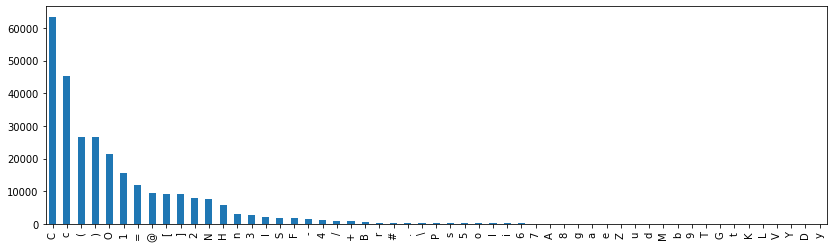

In [7]:
# char counts
pd.Series(tokenizer.word_counts).sort_values(ascending=False).plot(kind='bar', figsize=(14, 4))

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
print(Xtrain.shape, Xtest.shape)

(5481, 100, 56) (2350, 100, 56)


### train model

In [9]:
model = rnn_lm(input_len=ytrain.shape[1], vocab_size=ytrain.shape[2],
               **config['model_params'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 56)]         0         
_________________________________________________________________
gru (GRU)                    (None, 100, 64)           23424     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 56)           3640      
Total params: 27,064
Trainable params: 27,064
Non-trainable params: 0
_________________________________________________________________


In [10]:
if config['model_params']['embedding_size'] is None:
    model.fit(Xtrain, ytrain, **config['train_params'])
else:
    model.fit(Xtrain, ytrain, **config['train_params'])
    
pred = model.predict(Xtest)

Train on 4932 samples, validate on 549 samples
Epoch 1/10
4932/4932 [==============================] - 9s 2ms/sample - loss: 0.6146 - accuracy: 0.8272 - val_loss: 0.4093 - val_accuracy: 0.8695
Epoch 2/10
4932/4932 [==============================] - 8s 2ms/sample - loss: 0.3791 - accuracy: 0.8777 - val_loss: 0.3578 - val_accuracy: 0.8816
Epoch 3/10
4932/4932 [==============================] - 8s 2ms/sample - loss: 0.3428 - accuracy: 0.8875 - val_loss: 0.3381 - val_accuracy: 0.8889
Epoch 4/10
4932/4932 [==============================] - 9s 2ms/sample - loss: 0.3241 - accuracy: 0.8930 - val_loss: 0.3305 - val_accuracy: 0.8892
Epoch 5/10
4932/4932 [==============================] - 8s 2ms/sample - loss: 0.3126 - accuracy: 0.8962 - val_loss: 0.3203 - val_accuracy: 0.8927
Epoch 6/10
4932/4932 [==============================] - 8s 2ms/sample - loss: 0.3061 - accuracy: 0.8984 - val_loss: 0.3166 - val_accuracy: 0.8942
Epoch 7/10
4932/4932 [==============================] - 8s 2ms/sample - loss:

### analyze

In [24]:
def postprocess(pred, y):

    pred_idx = pred.argmax(axis=-1)
    y_idx = y.argmax(axis=-1)
    
    errors = (pred_idx != y_idx).astype(float)
    errors[y_idx == 0] = np.nan
    
    return pred_idx, y_idx, errors

accuracy

In [13]:
pred_idx, ytest_idx, errors = postprocess(pred, ytest)

print('Mean accuracy', 1-np.nanmean(errors))

Mean accuracy 0.7057046009932469


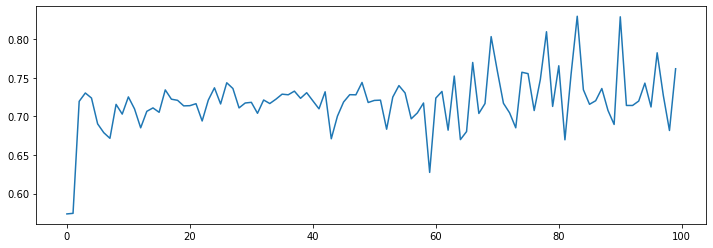

In [16]:
# mean accuracy  by position
plt.figure(figsize=(12,4))
plt.plot(1 - np.nanmean(errors, axis=0))

char counts

In [17]:
def get_char_counts(idx_matrix, idx2char):

    unique, counts = np.unique(idx_matrix, return_counts=True)
    counts = pd.Series(counts, index=unique)
    counts.drop(0, inplace=True)
    counts.index = counts.index.map(idx2char)

    return counts

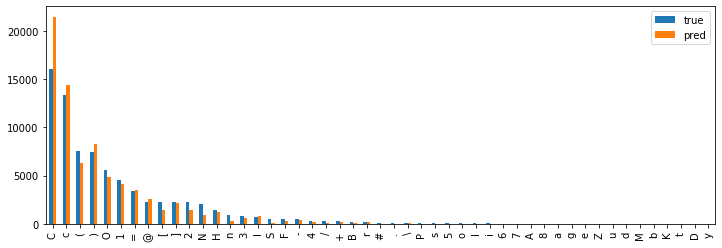

In [18]:
pred_char_counts = get_char_counts(pred_idx, idx2char)
ytest_char_counts = get_char_counts(ytest_idx, idx2char)

char_counts = ytest_char_counts.rename('true').to_frame().join(
    pred_char_counts.rename('pred')).fillna(0).astype(int)

char_counts.plot(kind='bar', figsize=(12, 4))

char counts by posiiton

In [19]:
def get_char_counts_by_position(idx_matrix, idx2char):

    counts_by_position = pd.DataFrame(idx_matrix).apply(lambda x: x.value_counts(), axis=0).fillna(0)
    counts_by_position.drop(0, inplace=True)
    counts_by_position.index = counts_by_position.index.map(idx2char)

    return counts_by_position

In [20]:
ytest_char_counts_by_position = get_char_counts_by_position(ytest_idx, idx2char)
pred_char_counts_by_position = get_char_counts_by_position(pred_idx, idx2char)
pred_char_counts_by_position = pred_char_counts_by_position.reindex(index=ytest_char_counts_by_position.index).fillna(0)

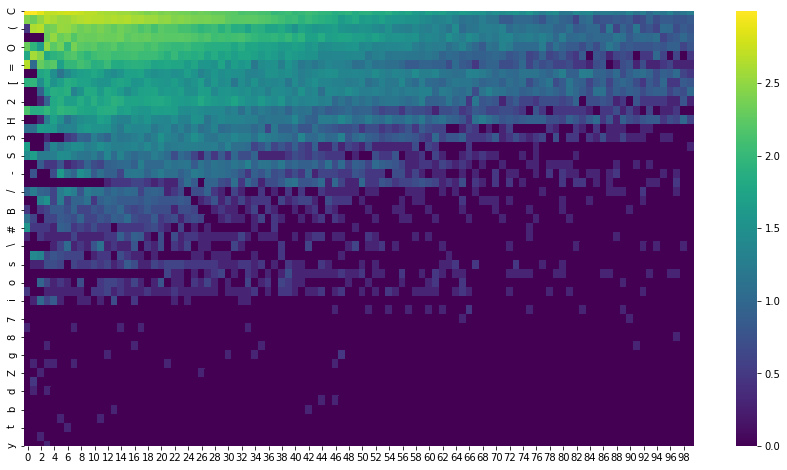

In [22]:
plt.figure(figsize=(15, 8))
sns.heatmap(np.log10(ytest_char_counts_by_position + 1), cmap='viridis')

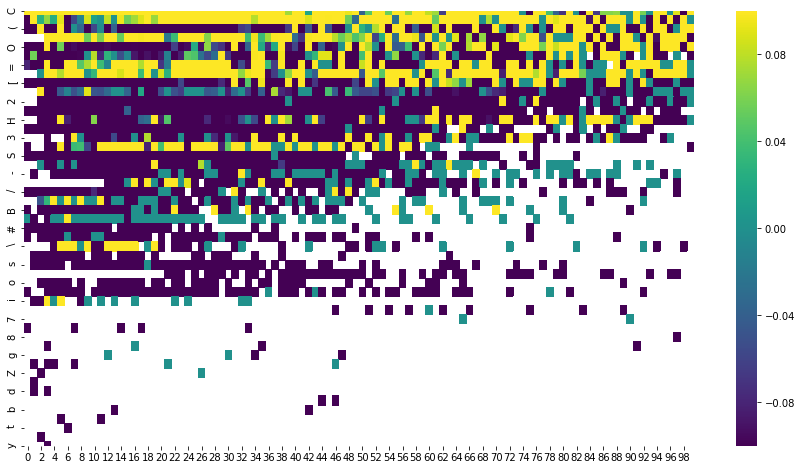

In [23]:
plt.figure(figsize=(15, 8))
sns.heatmap(pred_char_counts_by_position/ytest_char_counts_by_position - 1, cmap='viridis')